In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

c:\Users\isakm\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [3]:
device = torch.device("cuda")

In [4]:
T=100
betas = 0.05 * torch.ones(T, device=device)


In [5]:
alphas = torch.cumprod(1 - betas, 0)
mse = torch.nn.MSELoss(reduction='sum')
def loss (Xs, model):
    shape = Xs.size()
    count = Xs.size(dim = 0)
    t = torch.randint(low=0, high=T - 1, size=(count,), device = device).long()
    alpha_t = alphas[t].view(-1, 1, 1, 1)
    epsilon = torch.normal(0, 1, size=shape, device = device)
    pred = model(torch.sqrt(alpha_t) * Xs + torch.sqrt(1 - alpha_t) * epsilon, t)
    return mse(pred, epsilon)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
activation_function = nn.ReLU(inplace=True)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            activation_function,

            nn.Conv2d(out_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            activation_function

        )

    def forward(self, input):
        return self.conv(input)

class InputConvolution(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InputConvolution, self).__init__()
        self.inp_conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.inp_conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size = 2, stride = 2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x2, x1], dim = 1)
        x = self.conv(x)

        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class LastConvolution(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(LastConvolution, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv1(x)
        return x

class TimeEmb(nn.Module):
    def __init__(self, t_dim, H, W, C) -> None:
        super().__init__()
        self.t_dim = t_dim
        self.mlp = nn.Sequential(
            nn.Linear(t_dim, H * W * C),
            activation_function,
            nn.Unflatten(1, torch.Size([C, H, W]))
        )

    def forward(self, t):
        t = t.reshape(-1,1)
        emb = torch.arange(1, self.t_dim + 1, device = device)
        emb = torch.reshape(emb, (1,-1))
        emb = torch.cos(2 * torch.pi * self.t_dim / emb * t)
        return self.mlp(emb)


class Unet(nn.Module):
    def __init__(self, channels, classes):
        super(Unet, self).__init__()
        self.inp = InputConvolution(channels, 64)
        self.emb = TimeEmb(100, 28, 28, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.out = LastConvolution(64, classes)

    def forward(self, x, t):
        t0 = self.emb(t)
        x1 = self.inp(x) + t0
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.up1(x3, x2)
        x5 = self.up2(x4, x1)
        x6 = self.out(x5)
        return x6

epoch: 0 	loss: 411165.3125
epoch: 1 	loss: 403693.125
epoch: 2 	loss: 406009.34375
epoch: 3 	loss: 407494.03125
epoch: 4 	loss: 404191.9375
epoch: 5 	loss: 401837.15625
epoch: 6 	loss: 399500.4375
epoch: 7 	loss: 407087.21875
epoch: 8 	loss: 403247.40625
epoch: 9 	loss: 403114.34375
epoch: 10 	loss: 405029.53125
epoch: 11 	loss: 401794.5625
epoch: 12 	loss: 402651.71875
epoch: 13 	loss: 404489.78125
epoch: 14 	loss: 402269.28125
epoch: 15 	loss: 402023.625
epoch: 16 	loss: 400462.5625
epoch: 17 	loss: 400133.34375
epoch: 18 	loss: 402738.46875
epoch: 19 	loss: 400106.59375
epoch: 20 	loss: 405403.09375
epoch: 21 	loss: 399995.1875
epoch: 22 	loss: 399209.15625
epoch: 23 	loss: 401847.46875
epoch: 24 	loss: 403928.0
epoch: 25 	loss: 402190.1875
epoch: 26 	loss: 402282.59375
epoch: 27 	loss: 400469.0625
epoch: 28 	loss: 402156.375
epoch: 29 	loss: 401493.28125
epoch: 30 	loss: 399373.46875
epoch: 31 	loss: 400817.90625
epoch: 32 	loss: 401269.875
epoch: 33 	loss: 401529.6875
epoch: 34 	

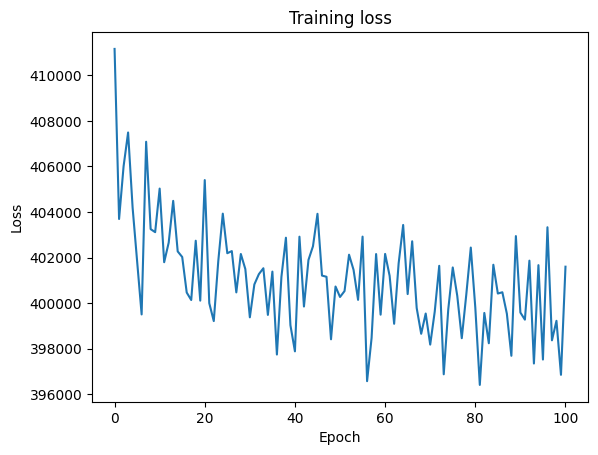

In [7]:

model = Unet(1,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-05)
model.train()
num_epochs = 201
loss_series = []
for e in range(num_epochs):
    epoch_loss = 0
    for data, _ in train_dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        l = loss(data,model)
        epoch_loss += l.detach().to('cpu')
        l.backward()
        optimizer.step()
    
    loss_series.append(epoch_loss)
    if e%10 == 0 and e > 0:
        torch.save(model.state_dict(), f"diffusion_model_{e}.pth")
    print("epoch:", e, "\tloss:", epoch_loss.item())

plt.plot(range(num_epochs), loss_series)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [7]:
model = Unet(1,1).to(device)
model.load_state_dict(torch.load(R"C:\Git\PML_course\Final\diffusion_model_200.pth"))
model.eval()

Unet(
  (inp): InputConvolution(
    (inp_conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (emb): TimeEmb(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=50176, bias=True)
      (1): ReLU(inplace=True)
      (2): Unflatten(dim=1, unflattened_size=torch.Size([64, 28, 28]))
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e

In [9]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def compute_mu(model, Xs, t):
    c1 = 1.0 / torch.sqrt(1 -betas[t]).view(-1,1,1,1)
    c2 = (betas[t] / torch.sqrt(1 - alphas[t])).view(-1,1,1,1)
    mu = c1 * (Xs - c2 * model(Xs, t))
    return mu


def generate_samples(model, num):
    Xs =  torch.normal(0.0, 1.0, size=(num, 1, 28, 28), dtype=torch.float32, device = device)
    shape = Xs.size()
    for s in range(0, T):
        t = T - s
        noise = torch.normal(0, torch.sqrt(betas[t - 1]), size = shape, device=device)
        if t == 1:
            noise *= 0
        tt = torch.tensor(num * [t - 1], device=device)
        Xs = compute_mu(model, Xs, tt) + noise
    return Xs

def generate_many_samples(model, count, batch_size):
    n_batches = int(count / batch_size) 
    result = torch.zeros(size=(0,1,28,28))
    for i in range(n_batches):
        samples = generate_samples(model, batch_size).detach().cpu()
        result = torch.cat([result, samples], dim = 0)
        if (i+1) % 10 == 0:
            print(f"Generated {i+1} batches of size {batch_size}")
    return result
    

model.eval()
device = 'cuda'
model = model.to(device)
betas = betas.to(device)
alphas = alphas.to(device)
with torch.no_grad():
    many_samples = generate_many_samples(model, 10000, 100).squeeze().numpy()
np.save(R"diffusion_samples.npy", many_samples)


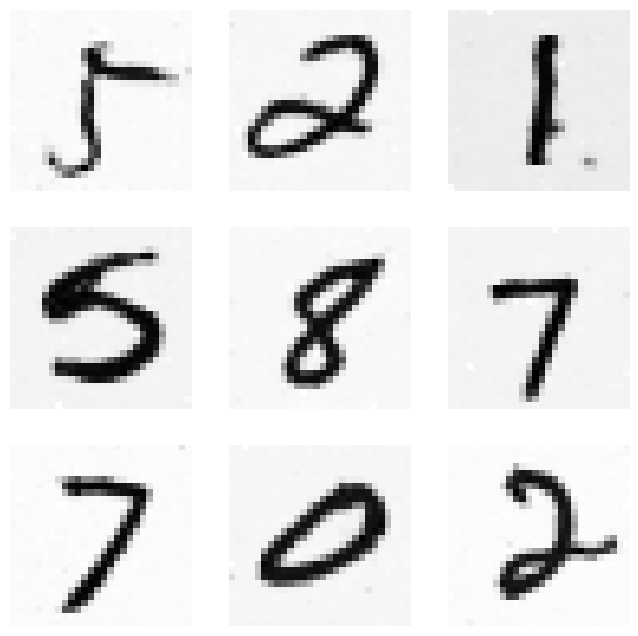

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(0, 9):
    img = many_samples[i]
    img = img.squeeze()
    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(img, cmap="gray_r")
plt.show()

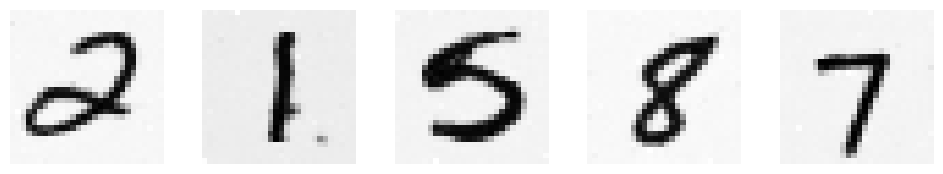

In [14]:
figure = plt.figure(figsize=(12, 2))
cols, rows = 5, 1
for i in range(1,  cols + 1):
    img = many_samples[i]
    # img=img.to('cpu').detach().numpy()
    img = img.reshape((1,1,28,28))
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.savefig("diffusion_samples.png")
plt.show()